In [1]:
#!/usr/bin/env python3

# author: Michael A. Perlin (github.com/perlinm)

import itertools, numpy, qiskit
import circuit_cutter
import mlrecon_methods as ml

import numpy as np
import qiskit
from qiskit import *
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, transpile

from qiskit.transpiler import PassManager

from qiskit.converters import circuit_to_dag
from qiskit.visualization import dag_drawer, plot_histogram
from qiskit.compiler import assemble
from qiskit.tools.monitor import job_monitor

# The pulse simulator
from qiskit.providers.aer import PulseSimulator

from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview

import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise import NoiseModel

from utils.utils import filter_results, dict_to_list, H_distance, total_counts

In [2]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.1',
 'qiskit-aer': '0.7.2',
 'qiskit-ignis': '0.5.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.1',
 'qiskit': '0.23.2'}

In [3]:
numpy.set_printoptions(linewidth = 200)

qubits = 5

# # should be "GHZ", "cascade", "dense", or "clustered"
# circuit_type = "GHZ"
# layers = 1 # number of gate layers

# qubits = 6 # number of qubits
# frag_num = 2 # number of fragments

simulation_backend = "qasm_simulator"

seed = 0
print_circuits = True

In [4]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='chm185')
provider.backends()

/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/circ_cutting/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_montreal') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_toronto') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_kolkata') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_guadalupe') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q-ornl', grou

In [5]:
device = provider.get_backend('ibmq_guadalupe')

In [8]:
noisy_simulator = provider.get_backend('ibmq_qasm_simulator')

In [9]:
front_layer = QuantumCircuit.from_qasm_file("qasm/vqe_5q_front.qasm")

In [10]:
mid_layer = QuantumCircuit.from_qasm_file("qasm/vqe_5q_mid.qasm")

In [11]:
end_layer = QuantumCircuit.from_qasm_file("qasm/vqe_5q_end.qasm")

In [12]:
orign_circuit = front_layer + mid_layer + end_layer

In [13]:
#checking circuit

In [14]:
def apply_checking_circuit(qc, ctrl_bits, ancilla_bits, side = None):
    if len(ctrl_bits) != len(ancilla_bits):
        print("Size mismatch")
        return None
    if side == 'front':
        for i in ancilla_bits:
            qc.h(i)
        for j,k in zip(ctrl_bits, ancilla_bits):
            qc.cz(j, k)
    elif side == 'end':
        for j,k in zip(ctrl_bits, ancilla_bits):
            qc.cz(j, k)
        for i in ancilla_bits:
            qc.h(i)
    else:
        print("Side undefined")

In [15]:
circuit = front_layer.copy()

In [16]:
apply_checking_circuit(circuit, [2], [5], side = 'front')
circuit += mid_layer
apply_checking_circuit(circuit, [2], [5], side = 'end')
circuit += end_layer

In [17]:
circuit.draw()

┌────────────┐   ┌────────────┐                                    
q_0: ─┤ RY(-4.751) ├─■─┤ RY(4.6739) ├────────────────────────────────────
      ├────────────┤ │ └────────────┘┌─────────────┐                     
q_1: ─┤ RY(3.1415) ├─■───────■───────┤ RY(-3.1415) ├─────────────────────
     ┌┴────────────┤         │       └─────────────┘       ┌────────────┐
q_2: ┤ RY(-3.8492) ├─■───────■──────────────■───────────■──┤ RY(0.7076) ├
     ├─────────────┤ │                      │           │  ├────────────┤
q_3: ┤ RY(-3.1416) ├─┼──────────────────────■────────■──┼──┤ RY(3.1415) ├
     ├─────────────┤ │                               │  │ ┌┴────────────┤
q_4: ┤ RY(-6.8335) ├─┼───────────────────────────────■──┼─┤ RY(-3.6921) ├
     └────┬───┬────┘ │                                  │ └────┬───┬────┘
q_5: ─────┤ H ├──────■──────────────────────────────────■──────┤ H ├─────
          └───┘                                                └───┘     
q_6: ────────────────────────────────────────────────────────────────────
                                                                         
q_7: ────────────────────────────────────────────────────────────────────
                                                                         
q_8: ────────────────────────────────────────────────────────────────────
                                                                         
q_9: ────────────────────────────────────────────────────────────────────

In [18]:
trans_qc = transpile(circuit, basis_gates = ['sx', 'cx', 'reset', 'id', 'x', 'rz'])

/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/circ_cutting/lib/python3.8/site-packages/qiskit/circuit/tools/pi_check.py:49: SymPyDeprecationWarning: 

The expr_free_symbols property is deprecated. Use free_symbols to get
the free symbols of an expression.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-expr-free-symbols
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  syms = inpt._symbol_expr.expr_free_symbols


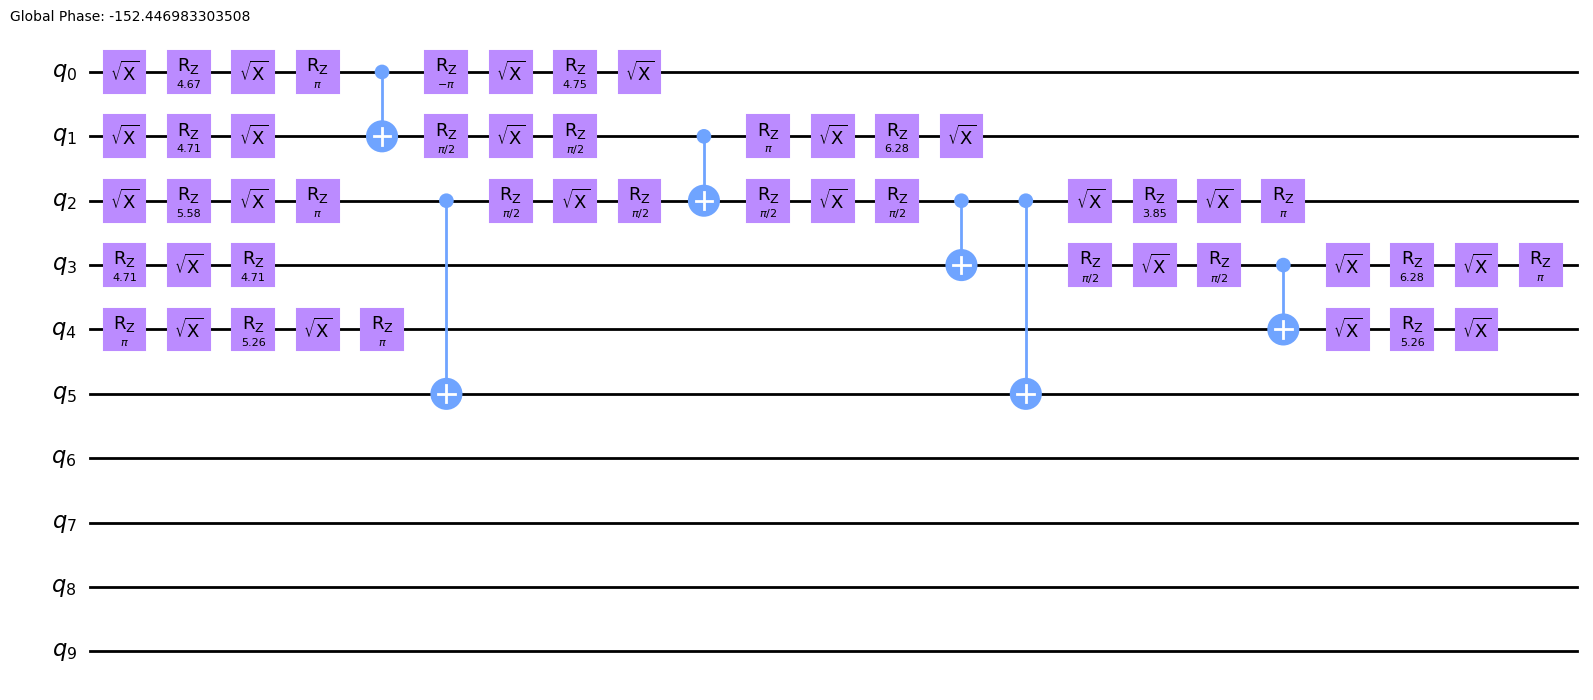

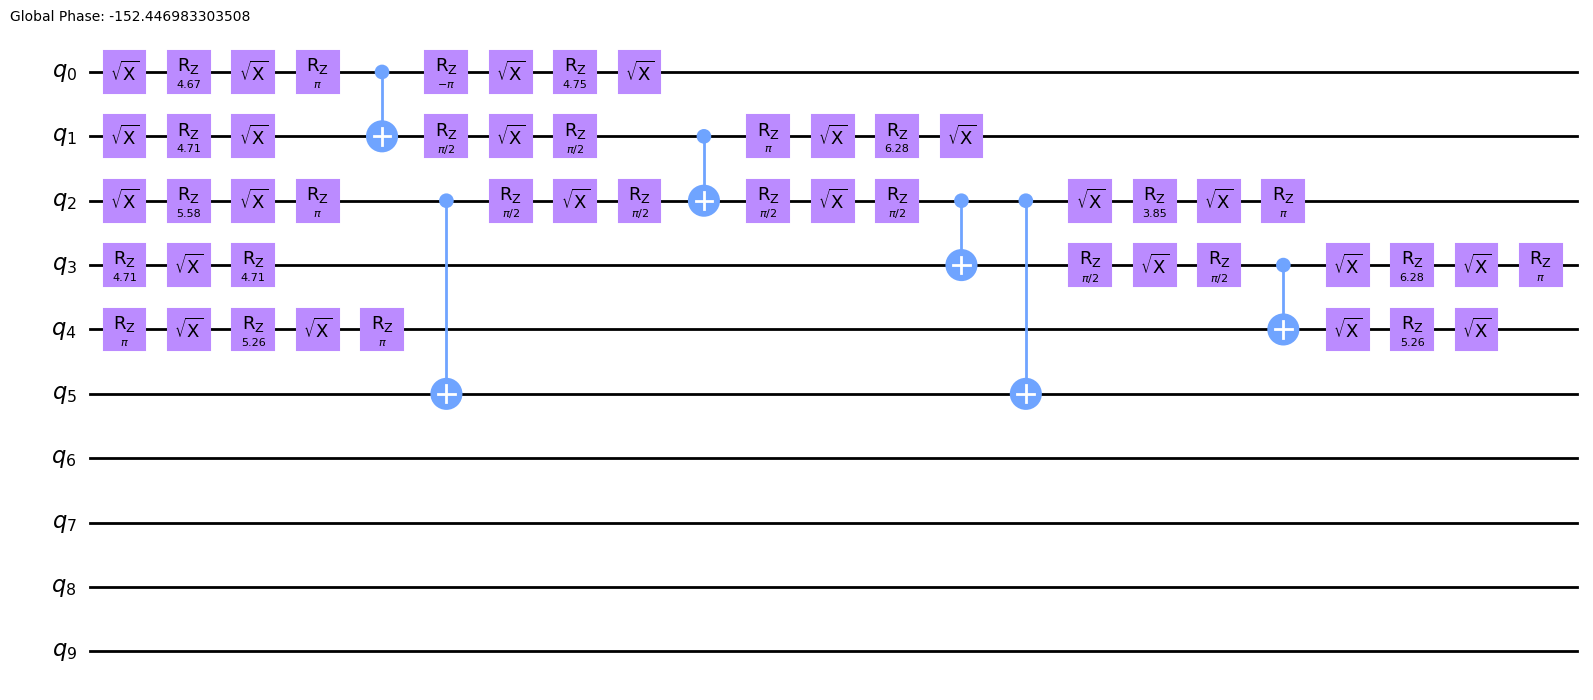

In [19]:
trans_qc.draw(output = 'mpl')

In [20]:
from qiskit import IBMQ, Aer
from qiskit.providers.aer.noise import NoiseModel
noise_model = NoiseModel.from_backend(device, gate_error = False, thermal_relaxation= False)
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'u3']
  Instructions with noise: ['measure']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  Specific qubit errors: [('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4]), ('measure', [5]), ('measure', [6]), ('measure', [7]), ('measure', [8]), ('measure', [9]), ('measure', [10]), ('measure', [11]), ('measure', [12]), ('measure', [13]), ('measure', [14]), ('measure', [15])]


In [21]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

In [22]:
# p_gate1 = 0.4
# error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
# error_gate2 = error_gate1.tensor(error_gate1)

In [23]:
# noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"])

In [24]:
circuit = trans_qc

In [25]:
cuts = []
# for i in range(0, 5):
#     if i == 0:
#         cut = [(circuit.qubits[i], 5),(circuit.qubits[i], 6)]
#     elif i == 3:
#         cut = [(circuit.qubits[i], 4),(circuit.qubits[i], 12)]
#     elif i == qubits-1:
#         cut = [(circuit.qubits[i], 5),(circuit.qubits[i], 12)]
#     else:
#         cut = [(circuit.qubits[i], 5),(circuit.qubits[i], 13)]
#     cuts += cut
cuts = [(circuit.qubits[2], 5),(circuit.qubits[2], 13)]

In [26]:
print(cuts)

[(Qubit(QuantumRegister(10, 'q'), 2), 5), (Qubit(QuantumRegister(10, 'q'), 2), 13)]


In [27]:
fragments, wire_path_map = circuit_cutter.cut_circuit(circuit, cuts)

unused qubits: [Qubit(QuantumRegister(10, 'q'), 6), Qubit(QuantumRegister(10, 'q'), 7), Qubit(QuantumRegister(10, 'q'), 8), Qubit(QuantumRegister(10, 'q'), 9)]


In [28]:
print(wire_path_map)

{Qubit(QuantumRegister(10, 'q'), 0): ((0, Qubit(QuantumRegister(5, 'q'), 0)),), Qubit(QuantumRegister(10, 'q'), 1): ((0, Qubit(QuantumRegister(5, 'q'), 1)),), Qubit(QuantumRegister(10, 'q'), 2): ((1, Qubit(QuantumRegister(3, 'q'), 0)), (0, Qubit(QuantumRegister(5, 'q'), 3)), (1, Qubit(QuantumRegister(3, 'q'), 1))), Qubit(QuantumRegister(10, 'q'), 3): ((0, Qubit(QuantumRegister(5, 'q'), 2)),), Qubit(QuantumRegister(10, 'q'), 4): ((0, Qubit(QuantumRegister(5, 'q'), 4)),), Qubit(QuantumRegister(10, 'q'), 5): ((1, Qubit(QuantumRegister(3, 'q'), 2)),), Qubit(QuantumRegister(10, 'q'), 6): ((2, Qubit(QuantumRegister(4, 'q'), 0)),), Qubit(QuantumRegister(10, 'q'), 7): ((2, Qubit(QuantumRegister(4, 'q'), 1)),), Qubit(QuantumRegister(10, 'q'), 8): ((2, Qubit(QuantumRegister(4, 'q'), 2)),), Qubit(QuantumRegister(10, 'q'), 9): ((2, Qubit(QuantumRegister(4, 'q'), 3)),)}


In [29]:
total_variants = ml.fragment_variants(wire_path_map)

In [30]:
total_variants

25

In [31]:
shots = 32000 * total_variants

In [32]:
if print_circuits:
    print("total circuit:")
    print(circuit)
    print("cuts:")
    for cut in cuts:
        print("",cut)
    print()
    for idx, fragment in enumerate(fragments):
        print(f"fragment {idx}:")
        print(fragment)
        print()
    fragment_cuts = ml.fragment_cuts(wire_path_map)
    print("fragment_index, prep_cuts, meas_cuts:")
    for frag_idx, frag_cuts in enumerate(fragment_cuts):
        print(frag_idx, frag_cuts["prep"], frag_cuts["meas"])
    print()
    print("total number of fragment variants:", total_variants)
    print("total number of shots:", ( shots // total_variants ) * total_variants)
    print()

total circuit:
global phase: -152.446983303508
         ┌────┐    ┌────────────┐    ┌────┐    ┌───────┐          ┌────────┐»
q_0: ────┤ √X ├────┤ RZ(4.6738) ├────┤ √X ├────┤ RZ(π) ├────■─────┤ RZ(-π) ├»
         ├────┤    ├────────────┤    ├────┤    └───────┘  ┌─┴─┐  ┌┴────────┤»
q_1: ────┤ √X ├────┤ RZ(4.7123) ├────┤ √X ├───────────────┤ X ├──┤ RZ(π/2) ├»
         ├────┤    ├────────────┤    ├────┤    ┌───────┐  └───┘  └─────────┘»
q_2: ────┤ √X ├────┤ RZ(5.5756) ├────┤ √X ├────┤ RZ(π) ├──────────────■─────»
     ┌───┴────┴───┐└───┬────┬───┘┌───┴────┴───┐└───────┘              │     »
q_3: ┤ RZ(4.7124) ├────┤ √X ├────┤ RZ(4.7124) ├───────────────────────┼─────»
     └─┬───────┬──┘    ├────┤    ├────────────┤  ┌────┐ ┌───────┐     │     »
q_4: ──┤ RZ(π) ├───────┤ √X ├────┤ RZ(5.2627) ├──┤ √X ├─┤ RZ(π) ├─────┼─────»
       └───────┘       └────┘    └────────────┘  └────┘ └───────┘   ┌─┴─┐   »
q_5: ───────────────────────────────────────────────────────────────┤ X ├───»
                 

In [33]:
print(fragment_cuts)

[{'prep': 1, 'meas': 1}, {'prep': 1, 'meas': 1}, {'prep': 0, 'meas': 0}]


In [34]:
# list of all possible measurement outcomes (bitstrings)
all_bits = [ "".join(bits) for bits in itertools.product(["0","1"], repeat = qubits) ]

In [35]:
print(all_bits)

['00000', '00001', '00010', '00011', '00100', '00101', '00110', '00111', '01000', '01001', '01010', '01011', '01100', '01101', '01110', '01111', '10000', '10001', '10010', '10011', '10100', '10101', '10110', '10111', '11000', '11001', '11010', '11011', '11100', '11101', '11110', '11111']


In [36]:
# # get the actual state / probability distribution for the full circuit
# actual_state = ml.get_statevector(circuit)
# actual_dist = { "".join(bits) : abs(amp)**2
#                 for bits, amp in zip(all_bits, actual_state)
#                 if amp != 0 }

# # get a simulated probability distribution for the full circuit
# circuit.measure_active()
# full_circuit_result = ml.run_circuits(circuit, shots, backend = simulation_backend)
# full_circuit_dist = {}
# for part in full_circuit_result:
#     for bits, counts in part.get_counts(circuit).items():
#         if bits not in full_circuit_dist:
#             full_circuit_dist[bits] = 0
#         full_circuit_dist[bits] += counts / shots

In [37]:
wire_path_map

{Qubit(QuantumRegister(10, 'q'), 0): ((0, Qubit(QuantumRegister(5, 'q'), 0)),),
 Qubit(QuantumRegister(10, 'q'), 1): ((0, Qubit(QuantumRegister(5, 'q'), 1)),),
 Qubit(QuantumRegister(10, 'q'), 2): ((1, Qubit(QuantumRegister(3, 'q'), 0)),
  (0, Qubit(QuantumRegister(5, 'q'), 3)),
  (1, Qubit(QuantumRegister(3, 'q'), 1))),
 Qubit(QuantumRegister(10, 'q'), 3): ((0, Qubit(QuantumRegister(5, 'q'), 2)),),
 Qubit(QuantumRegister(10, 'q'), 4): ((0, Qubit(QuantumRegister(5, 'q'), 4)),),
 Qubit(QuantumRegister(10, 'q'), 5): ((1, Qubit(QuantumRegister(3, 'q'), 2)),),
 Qubit(QuantumRegister(10, 'q'), 6): ((2, Qubit(QuantumRegister(4, 'q'), 0)),),
 Qubit(QuantumRegister(10, 'q'), 7): ((2, Qubit(QuantumRegister(4, 'q'), 1)),),
 Qubit(QuantumRegister(10, 'q'), 8): ((2, Qubit(QuantumRegister(4, 'q'), 2)),),
 Qubit(QuantumRegister(10, 'q'), 9): ((2, Qubit(QuantumRegister(4, 'q'), 3)),)}

In [38]:
orign_qc = QuantumCircuit.from_qasm_file("qasm/vqe_5q.qasm")
orign_qc.measure_all()

In [39]:
orign_qc = transpile(orign_qc, basis_gates = ['sx', 'cx', 'reset', 'id', 'x', 'rz'])

In [40]:
orign_qc.draw()

global phase: -110.035482480046
            ┌────┐    ┌────────────┐    ┌────┐    ┌───────┐          ┌────────┐»
   q_0: ────┤ √X ├────┤ RZ(4.6738) ├────┤ √X ├────┤ RZ(π) ├────■─────┤ RZ(-π) ├»
            ├────┤    ├────────────┤    ├────┤    └───────┘  ┌─┴─┐  ┌┴────────┤»
   q_1: ────┤ √X ├────┤ RZ(4.7123) ├────┤ √X ├───────────────┤ X ├──┤ RZ(π/2) ├»
            ├────┤    ├────────────┤    ├────┤               └───┘  └─────────┘»
   q_2: ────┤ √X ├────┤ RZ(4.0048) ├────┤ √X ├─────────────────────────────────»
        ┌───┴────┴───┐└───┬────┬───┘┌───┴────┴───┐                             »
   q_3: ┤ RZ(4.7124) ├────┤ √X ├────┤ RZ(4.7124) ├─────────────────────────────»
        └─┬───────┬──┘    ├────┤    ├────────────┤  ┌────┐ ┌───────┐           »
   q_4: ──┤ RZ(π) ├───────┤ √X ├────┤ RZ(5.2627) ├──┤ √X ├─┤ RZ(π) ├───────────»
          └───────┘       └────┘    └────────────┘  └────┘ └───────┘           »
meas: 5/═══════════════════════════════════════════════════════════════════════»
                                                                               »
«        ┌────┐┌────────────┐┌────┐                                     »
«   q_0: ┤ √X ├┤ RZ(4.7509) ├┤ √X ├─────────────────────────────────────»
«        ├────┤└┬─────────┬─┘└────┘ ┌───────┐ ┌────┐┌────────────┐┌────┐»
«   q_1: ┤ √X ├─┤ RZ(π/2) ├────■────┤ RZ(π) ├─┤ √X ├┤ RZ(6.2831) ├┤ √X ├»
«        └────┘ └─────────┘  ┌─┴─┐ ┌┴───────┴┐├────┤└┬─────────┬─┘└────┘»
«   q_2: ────────────────────┤ X ├─┤ RZ(π/2) ├┤ √X ├─┤ RZ(π/2) ├────■───»
«                            └───┘ └─────────┘└────┘ └─────────┘  ┌─┴─┐ »
«   q_3: ─────────────────────────────────────────────────────────┤ X ├─»
«                                                                 └───┘ »
«   q_4: ───────────────────────────────────────────────────────────────»
«                                                                       »
«meas: 5/═══════════════════════════════════════════════════════════════»
«                                                                       »
«                                                                         »
«   q_0: ─────────────────────────────────────────────────────────────────»
«                                                                         »
«   q_1: ─────────────────────────────────────────────────────────────────»
«           ┌────┐  ┌────────────┐   ┌────┐  ┌───────┐                    »
«   q_2: ───┤ √X ├──┤ RZ(3.8492) ├───┤ √X ├──┤ RZ(π) ├────────────────────»
«        ┌──┴────┴─┐└───┬────┬───┘┌──┴────┴─┐└───────┘┌────┐┌────────────┐»
«   q_3: ┤ RZ(π/2) ├────┤ √X ├────┤ RZ(π/2) ├────■────┤ √X ├┤ RZ(6.2831) ├»
«        └─────────┘    └────┘    └─────────┘  ┌─┴─┐  ├────┤├────────────┤»
«   q_4: ──────────────────────────────────────┤ X ├──┤ √X ├┤ RZ(5.2629) ├»
«                                              └───┘  └────┘└────────────┘»
«meas: 5/═════════════════════════════════════════════════════════════════»
«                                                                         »
«                        ░ ┌─┐            
«   q_0: ────────────────░─┤M├────────────
«                        ░ └╥┘┌─┐         
«   q_1: ────────────────░──╫─┤M├─────────
«                        ░  ║ └╥┘┌─┐      
«   q_2: ────────────────░──╫──╫─┤M├──────
«        ┌────┐┌───────┐ ░  ║  ║ └╥┘┌─┐   
«   q_3: ┤ √X ├┤ RZ(π) ├─░──╫──╫──╫─┤M├───
«        ├────┤└───────┘ ░  ║  ║  ║ └╥┘┌─┐
«   q_4: ┤ √X ├──────────░──╫──╫──╫──╫─┤M├
«        └────┘          ░  ║  ║  ║  ║ └╥┘
«meas: 5/═══════════════════╩══╩══╩══╩══╩═
«                           0  1  2  3  4

In [41]:
len(fragments)

3

In [42]:
temp_frag_data = [0] * len(fragments)

In [43]:
fragments[0].draw()

┌────┐    ┌────────────┐    ┌────┐    ┌───────┐          ┌────────┐»
q_0: ────┤ √X ├────┤ RZ(4.6738) ├────┤ √X ├────┤ RZ(π) ├────■─────┤ RZ(-π) ├»
         ├────┤    ├────────────┤    ├────┤    └───────┘  ┌─┴─┐  ┌┴────────┤»
q_1: ────┤ √X ├────┤ RZ(4.7123) ├────┤ √X ├───────────────┤ X ├──┤ RZ(π/2) ├»
     ┌───┴────┴───┐└───┬────┬───┘┌───┴────┴───┐           └───┘  └─────────┘»
q_2: ┤ RZ(4.7124) ├────┤ √X ├────┤ RZ(4.7124) ├─────────────────────────────»
     └┬─────────┬─┘    ├────┤    └┬─────────┬─┘                             »
q_3: ─┤ RZ(π/2) ├──────┤ √X ├─────┤ RZ(π/2) ├───────────────────────────────»
      └┬───────┬┘      ├────┤    ┌┴─────────┴─┐  ┌────┐ ┌───────┐           »
q_4: ──┤ RZ(π) ├───────┤ √X ├────┤ RZ(5.2627) ├──┤ √X ├─┤ RZ(π) ├───────────»
       └───────┘       └────┘    └────────────┘  └────┘ └───────┘           »
«     ┌────┐┌────────────┐┌────┐                                     »
«q_0: ┤ √X ├┤ RZ(4.7509) ├┤ √X ├─────────────────────────────────────»
«     ├────┤└┬─────────┬─┘└────┘ ┌───────┐ ┌────┐┌────────────┐┌────┐»
«q_1: ┤ √X ├─┤ RZ(π/2) ├────■────┤ RZ(π) ├─┤ √X ├┤ RZ(6.2831) ├┤ √X ├»
«     └────┘ └─────────┘    │    └───────┘ └────┘└────────────┘├───┬┘»
«q_2: ──────────────────────┼──────────────────────────────────┤ X ├─»
«                         ┌─┴─┐ ┌─────────┐┌────┐ ┌─────────┐  └─┬─┘ »
«q_3: ────────────────────┤ X ├─┤ RZ(π/2) ├┤ √X ├─┤ RZ(π/2) ├────■───»
«                         └───┘ └─────────┘└────┘ └─────────┘        »
«q_4: ───────────────────────────────────────────────────────────────»
«                                                                    »
«                                                                         
«q_0: ────────────────────────────────────────────────────────────────────
«                                                                         
«q_1: ────────────────────────────────────────────────────────────────────
«     ┌─────────┐┌────┐┌─────────┐     ┌────┐┌────────────┐┌────┐┌───────┐
«q_2: ┤ RZ(π/2) ├┤ √X ├┤ RZ(π/2) ├──■──┤ √X ├┤ RZ(6.2831) ├┤ √X ├┤ RZ(π) ├
«     └─────────┘└────┘└─────────┘  │  └────┘└────────────┘└────┘└───────┘
«q_3: ──────────────────────────────┼─────────────────────────────────────
«                                 ┌─┴─┐┌────┐┌────────────┐┌────┐         
«q_4: ────────────────────────────┤ X ├┤ √X ├┤ RZ(5.2629) ├┤ √X ├─────────
«                                 └───┘└────┘└────────────┘└────┘

In [44]:
for i in range(0, len(fragments)):
    if i == 0:
        temp_frag_data[i] = ml.collect_fragment_raw_data(fragments[i], i, wire_path_map,
                                     shots = shots // total_variants,
                                     tomography_backend = device, initial_layout = [5,3,1,2,4], opt_lvl = 3, extra_qc = [orign_qc])
    else:
        temp_frag_data[i] = ml.collect_fragment_raw_data(fragments[i], i, wire_path_map,
                                     shots = shots // total_variants,
                                     tomography_backend = simulation_backend)

/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/circ_cutting/lib/python3.8/site-packages/qiskit/ignis/verification/tomography/basis/sicbasis.py:48: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  circ.u3(theta, np.pi, 0.0, qubit)


Job Status: job has successfully run
job_id:  635bff75b0c060d788abe313
Job Status: job has successfully run
job_id:  eb0002fe-71c3-4147-b894-912ce994edc7
Job Status: job has successfully run
job_id:  4adfb469-3575-4342-a3ef-5da14300fd74


In [45]:
#     temp_frag_data[i] = ml.collect_fragment_raw_data(fragments[i], i, wire_path_map,
#                                      shots = shots // total_variants,
#                                      tomography_backend = simulation_backend)

In [46]:
# for i in range(1, len(fragments)):
#     temp_frag_data[i] = ml.collect_fragment_raw_data(fragments[i], i, wire_path_map,
#                                      shots = shots // total_variants,
#                                      tomography_backend = simulation_backend)

In [47]:
frag_targets = ml.identify_frag_targets(wire_path_map)

In [48]:
frag_data = []
for i in range(0, len(fragments)):
    extra_list = []
    if i == 0:
        extra_list = [orign_qc]
    frag_data.append(ml.organize_tomography_data(temp_frag_data[i][0],
                                      frag_targets[i].get("prep"),
                                      frag_targets[i].get("meas"),
                                      prep_basis = "SIC", extra_qc = extra_list))

In [49]:
len(frag_data)

3

In [50]:
# frag_data = [ml.organize_tomography_data(temp_frag_data[0][0],
#                                       frag_targets[0].get("prep"),
#                                       frag_targets[0].get("meas"),
#                                       prep_basis = "SIC", extra_qc = [orign_qc])]
# for i in range(1, len(fragments)):
#     frag_data.append(ml.organize_tomography_data(temp_frag_data[i][0],
#                                       frag_targets[i].get("prep"),
#                                       frag_targets[i].get("meas"),
#                                       prep_basis = "SIC", extra_qc = []))

In [51]:
direct_models = ml.direct_fragment_model(frag_data)
likely_models = ml.maximum_likelihood_model(direct_models)

direct_recombined_dist = ml.recombine_fragment_models(direct_models, wire_path_map)
likely_recombined_dist = ml.recombine_fragment_models(likely_models, wire_path_map)

In [52]:
direct_recombined_dist

{'0000000000': 0.0006847523275808463,
 '0000000100': 0.019190644626426938,
 '0000100000': 0.004781352934482246,
 '0000100100': 0.0007623384468161261,
 '0000000001': 0.003101501168908702,
 '0000000101': 0.14603622156562593,
 '0000100001': 0.0241517709813108,
 '0000100101': 0.004154143598218668,
 '0000010000': 0.0036956697244275106,
 '0000010100': 0.06451167810635657,
 '0000110000': 0.01324137831949676,
 '0000110100': 0.0012831010722819285,
 '0000010001': 0.026439571933989575,
 '0000010101': 0.49795420592512857,
 '0000110001': 0.05457934976775416,
 '0000110101': 0.005998035544103057,
 '0000010010': 0.005207912692262867,
 '0000010110': 0.008983670400362685,
 '0000110010': 0.015905285119287568,
 '0000110110': 0.0029786651087742432,
 '0000010011': 0.0037438731534335905,
 '0000010111': 0.019638223704477695,
 '0000110011': 0.004862691898022656,
 '0000110111': 0.0007616159549022916,
 '0000011000': 0.0005424744747272348,
 '0000011100': 0.002021332798088923,
 '0000111000': 0.0010772610593837986,

In [53]:
likely_recombined_dist

{'0000000000': 0.0006204298932898587,
 '0000000100': 0.01885856398988497,
 '0000100000': 0.004258756026771857,
 '0000100100': 0.0006425826551601524,
 '0000000001': 0.004545690125562714,
 '0000000101': 0.1488930735962327,
 '0000100001': 0.02375460083619438,
 '0000100101': 0.004406388540030439,
 '0000010000': 0.003679065062154981,
 '0000010100': 0.06455721721767653,
 '0000110000': 0.012793554339374257,
 '0000110100': 0.0011481760758907619,
 '0000010001': 0.028071758225101388,
 '0000010101': 0.5032157355737786,
 '0000110001': 0.05457888184160102,
 '0000110101': 0.008408221902910677,
 '0000010010': 0.005100487463373719,
 '0000010110': 0.00926389402188095,
 '0000110010': 0.015524066474379877,
 '0000110110': 0.0029432872133957513,
 '0000010011': 0.0036431693598861135,
 '0000010111': 0.019272586813943653,
 '0000110011': 0.004335801593185171,
 '0000110111': 0.0006552177776763041,
 '0000011000': 0.0004071375177686341,
 '0000011100': 0.0015046660949210964,
 '0000111000': 0.0005817587282342985,
 

In [54]:
from utils.utils import filter_results

In [55]:
filter_direct_recombined = filter_results(direct_recombined_dist, [0,1,2,3,4])

In [56]:
filter_direct_recombined

{'00000': 0.0006847523275808463,
 '00100': 0.019190644626426938,
 '00001': 0.003101501168908702,
 '00101': 0.14603622156562593,
 '10000': 0.0036956697244275106,
 '10100': 0.06451167810635657,
 '10001': 0.026439571933989575,
 '10101': 0.49795420592512857,
 '10010': 0.005207912692262867,
 '10110': 0.008983670400362685,
 '10011': 0.0037438731534335905,
 '10111': 0.019638223704477695,
 '11000': 0.0005424744747272348,
 '11100': 0.002021332798088923,
 '11001': 0.006748469772488822,
 '11101': 0.011206215236498996,
 '11010': 0.00014798685934523323,
 '11110': 0.000795840143582386,
 '11011': 0.0002659831169792678,
 '11111': 0.0005651474667002364,
 '00010': 0.0017555200278279832,
 '00110': 0.002466464733062861,
 '00011': 0.0009286886695779609,
 '00111': 0.005658721857394162,
 '01000': 0.00030345092854860674,
 '01100': 0.0010347853445797164,
 '01001': 0.0032412948907177843,
 '01101': 0.005803572668632304,
 '01010': 0.00013145580973668202,
 '01110': 0.00022827859740973374,
 '01011': 0.0001581672759

In [57]:
filter_likely_recombined = filter_results(likely_recombined_dist, [0,1,2,3,4])

In [58]:
filter_likely_recombined

{'00000': 0.0006204298932898587,
 '00100': 0.01885856398988497,
 '00001': 0.004545690125562714,
 '00101': 0.1488930735962327,
 '10000': 0.003679065062154981,
 '10100': 0.06455721721767653,
 '10001': 0.028071758225101388,
 '10101': 0.5032157355737786,
 '10010': 0.005100487463373719,
 '10110': 0.00926389402188095,
 '10011': 0.0036431693598861135,
 '10111': 0.019272586813943653,
 '11000': 0.0004071375177686341,
 '11100': 0.0015046660949210964,
 '11001': 0.006640607824095297,
 '11101': 0.010788281397635113,
 '11010': 1.865758073310792e-05,
 '11110': 0.00032657199463229016,
 '11011': 0.00012418860207649967,
 '11111': 7.772249608650853e-05,
 '00010': 0.0016239402440035727,
 '00110': 0.002707202787754817,
 '00011': 0.0007928482535321798,
 '00111': 0.005151638500017705,
 '01000': 0.00016106906374893212,
 '01100': 0.0004900926964257912,
 '01001': 0.0031137292516837676,
 '01101': 0.005308960092686907,
 '01010': 2.0426297457189492e-05,
 '01110': 5.7555537673395e-06,
 '01011': 3.0481448672164148e-

In [59]:
def norm_dict(dictionary):
    total = total_counts(dictionary)
    norm_dist = {}
    for i in dictionary.keys():
        norm_dist[i] = dictionary[i]/total
    return norm_dist

In [60]:
unmiti_dist = temp_frag_data[0][0][0].get_counts()[-1]
unmiti_dist

{'00000': 98,
 '00001': 531,
 '10000': 457,
 '10001': 1983,
 '10010': 819,
 '10011': 360,
 '10100': 2455,
 '10101': 15938,
 '10110': 275,
 '10111': 679,
 '11000': 318,
 '11001': 635,
 '11010': 103,
 '11011': 144,
 '11100': 213,
 '11101': 494,
 '11110': 54,
 '11111': 95,
 '00010': 219,
 '00011': 90,
 '00100': 604,
 '00101': 4104,
 '00110': 87,
 '00111': 155,
 '01000': 169,
 '01001': 332,
 '01010': 63,
 '01011': 91,
 '01100': 105,
 '01101': 243,
 '01110': 28,
 '01111': 59}

In [61]:
unmiti_norm_dist = norm_dict(unmiti_dist)

In [62]:
norm_filter_dist = norm_dict(filter_likely_recombined)

In [63]:
unmiti_norm_dist['10101']

0.4980625

In [64]:
likely_recombined_dist['0000010101']

0.5032157355737786

In [65]:
norm_filter_dist['10101']

0.592670046884051

In [66]:
norm_filter_dist

{'00000': 0.0007307208180306509,
 '00100': 0.022210962841427893,
 '00001': 0.005353756230944865,
 '00101': 0.17536109996316238,
 '10000': 0.004333075277128686,
 '10100': 0.07603325224215804,
 '10001': 0.03306194359049275,
 '10101': 0.592670046884051,
 '10010': 0.006007177300611289,
 '10110': 0.01091069320003823,
 '10011': 0.004290798563499355,
 '10111': 0.02269858456944508,
 '11000': 0.000479512452982136,
 '11100': 0.0017721435598688302,
 '11001': 0.007821077665541576,
 '11101': 0.01270606380073602,
 '11010': 2.1974251729679483e-05,
 '11110': 0.00038462517303646665,
 '11011': 0.00014626502991052148,
 '11111': 9.153886125403737e-05,
 '00010': 0.0019126205174269319,
 '00110': 0.0031884495847766298,
 '00011': 0.0009337891849845806,
 '00111': 0.006067421218165642,
 '01000': 0.00018970155902379144,
 '01100': 0.0005772141863509325,
 '01001': 0.0036672423597316054,
 '01101': 0.006252709135676439,
 '01010': 2.4057384965945976e-05,
 '01110': 6.778691682292703e-06,
 '01011': 3.589999345514637e-0

In [67]:
total_counts(unmiti_dist)

32000

In [68]:
unmiti_norm_dist = {}
for i in unmiti_dist.keys():
    unmiti_norm_dist[i] = unmiti_dist[i]/total_counts(unmiti_dist)

In [69]:
unmiti_norm_dist

{'00000': 0.0030625,
 '00001': 0.01659375,
 '10000': 0.01428125,
 '10001': 0.06196875,
 '10010': 0.02559375,
 '10011': 0.01125,
 '10100': 0.07671875,
 '10101': 0.4980625,
 '10110': 0.00859375,
 '10111': 0.02121875,
 '11000': 0.0099375,
 '11001': 0.01984375,
 '11010': 0.00321875,
 '11011': 0.0045,
 '11100': 0.00665625,
 '11101': 0.0154375,
 '11110': 0.0016875,
 '11111': 0.00296875,
 '00010': 0.00684375,
 '00011': 0.0028125,
 '00100': 0.018875,
 '00101': 0.12825,
 '00110': 0.00271875,
 '00111': 0.00484375,
 '01000': 0.00528125,
 '01001': 0.010375,
 '01010': 0.00196875,
 '01011': 0.00284375,
 '01100': 0.00328125,
 '01101': 0.00759375,
 '01110': 0.000875,
 '01111': 0.00184375}